# Self-Driving Car Engineer Nanodegree


## Project 1: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). 

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
# importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


%load_ext lab_black
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


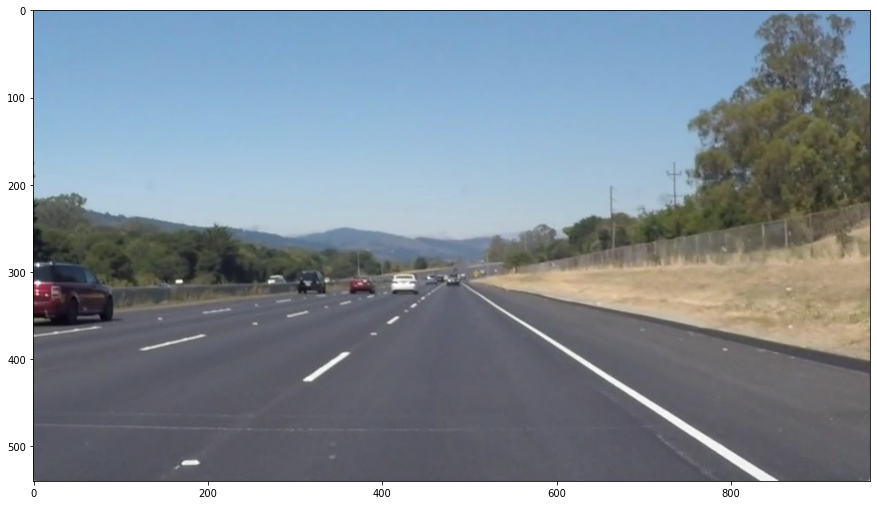

In [2]:
# reading in an image
image = mpimg.imread("test_images/solidWhiteRight.jpg")

plt.figure(figsize=(15, 10))

# printing out some stats and plotting
print("This image is:", type(image), "with dimensions:", image.shape)
plt.imshow(
    image
)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Image Transformations

### 1. Color Selection

previously tried using solely grey filter, some of the images will have issues finding the correct lanes as the algorithm is confounded by the surrounding background

In [3]:
def hls_scale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

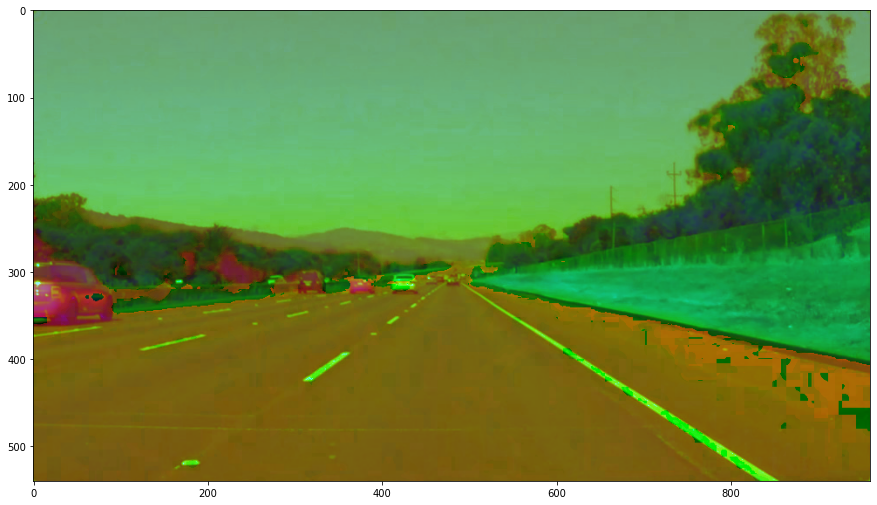

In [4]:
plt.figure(figsize=(15, 10))
plt.imshow(hls_scale(image))
plt.show()

filter out all colors other than white and yellow

In [5]:
def color_filter(image):
    """ Create a color mask that only persists yellow and white color """
    converted = hls_scale(image)

    # white color mask
    lower = np.uint8([0, 150, 0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)

    # yellow color mask
    lower = np.uint8([50, 0, 100])
    upper = np.uint8([100, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)

    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask=mask)

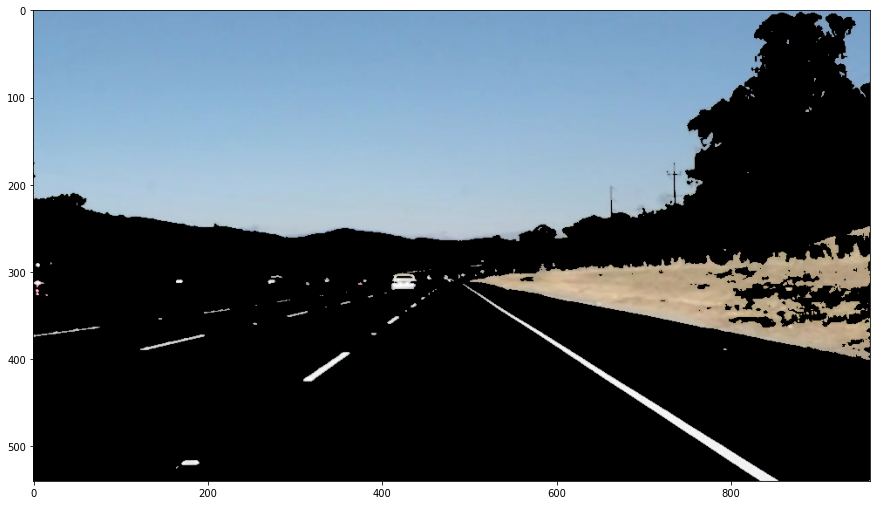

In [6]:
plt.figure(figsize=(15, 10))
plt.imshow(color_filter(image))
plt.imsave("examples/color_filter.jpg", color_filter(image))
plt.show()

### 2. gaussian blur image

In [7]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

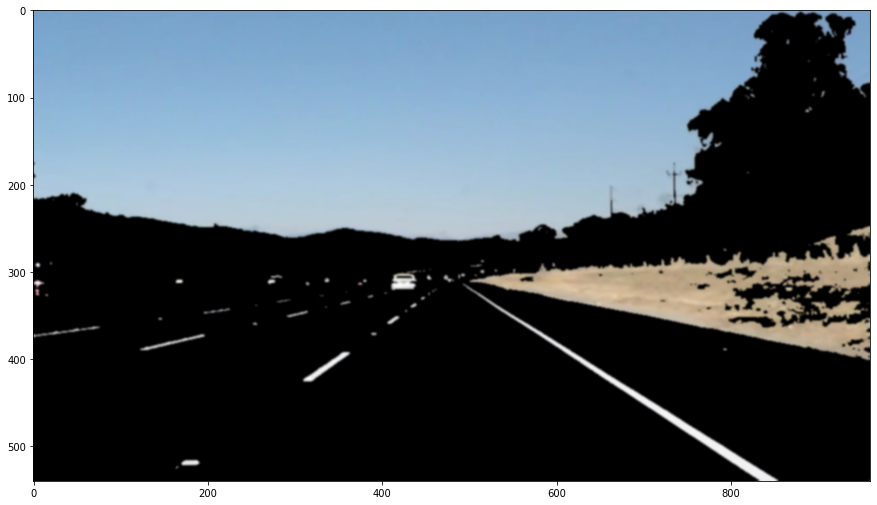

In [8]:
plt.figure(figsize=(15, 10))
plt.imshow(gaussian_blur(color_filter(image), kernel_size=5), cmap="gray")
plt.imsave("examples/gaussian_blur.jpg", color_filter(image))
plt.show()

### 3. Canny Edge Detection

In [9]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

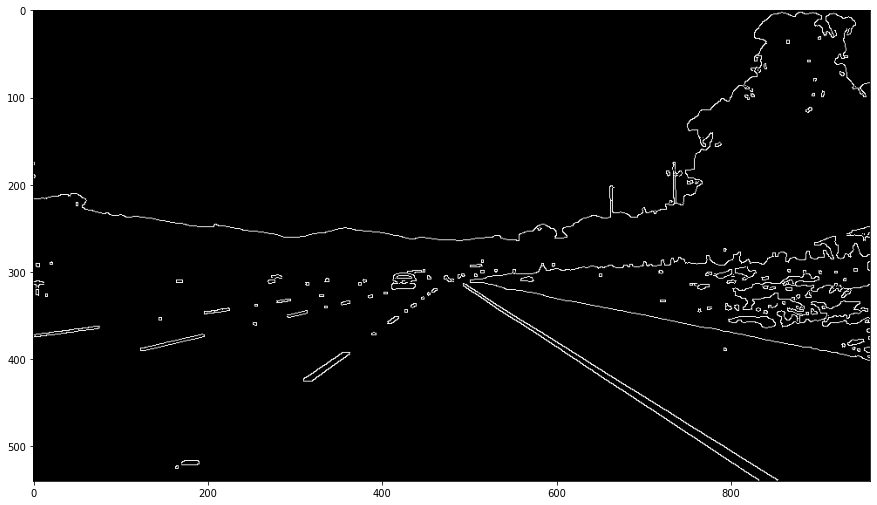

In [10]:
plt.figure(figsize=(15, 10))
plt.imshow(
    canny(gaussian_blur(color_filter(image), 5), low_threshold=50, high_threshold=150),
    cmap="gray",
)
plt.imsave(
    "examples/canny_edge_detect.jpg",
    canny(gaussian_blur(color_filter(image), 5), low_threshold=50, high_threshold=150),
    cmap="gray",
)
plt.show()

### 4. Select Region of Interest

Caney has detected a lot of edges in the image, while we are only interested in the lane lines, we will restrict the region of interest in trapzoid region in front of the camera

In [11]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

The filtered image becomes the following

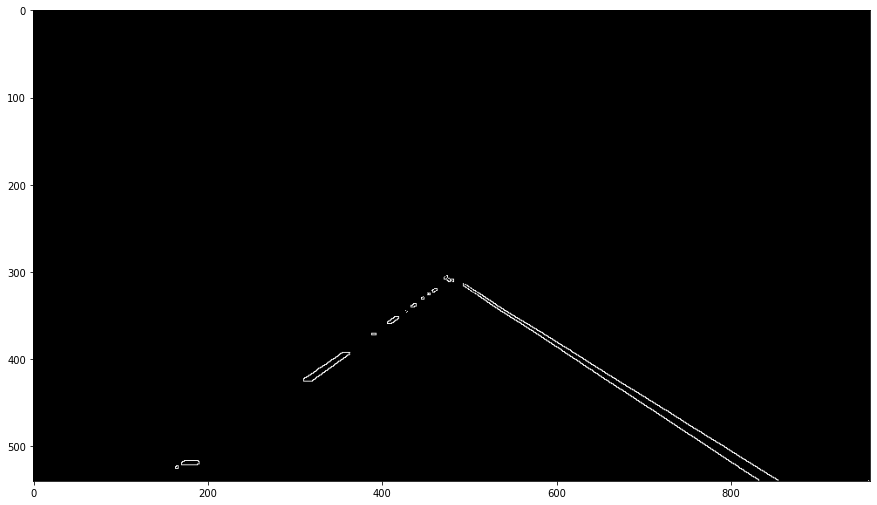

In [12]:
# convert to gray scale
img_filtered = color_filter(image.copy())

# add gaussian blur
img_filtered_blur = gaussian_blur(img_filtered, kernel_size=3)

# canny edge detection
low_threshold = 100
high_threshold = 200

edge_detected_img = canny(img_filtered_blur, low_threshold, high_threshold)

# mask image except region of interest
img_height, img_width = edge_detected_img.shape
region_vertices = np.array(
    [
        [int(0.48 * img_width), int(0.55 * img_height)],
        [int(0.51 * img_width), int(0.55 * img_height)],
        [0, img_height],
        [img_width, img_height],
    ],
    dtype=np.int32,
)

region_masked_img = region_of_interest(
    img=edge_detected_img, vertices=[region_vertices]
)

plt.figure(figsize=(15, 10))
plt.imshow(region_masked_img, cmap="gray")
plt.imsave("examples/region_masked.jpg", region_masked_img, cmap="gray")
plt.show()

### 5. draw full lines over detected lane lines

We will use hough lines to lay a detected line over the image. To get a full extended line through the lane, we will use extrapolation over all the small detected line segments and restrict the slope being too far away from the lane

function that converts the slope, intercept to line segment end points

In [13]:
def get_line_end_pts(line_segment, y1, y2):
    """ Convert line segment of slope and intercept to line end points"""
    if line_segment is None:
        return None

    slope, intercept = line_segment

    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    y1 = int(y1)
    y2 = int(y2)

    return x1, y1, x2, y2

The following function will generate both left and right lane in forms of slope and intercept

In [14]:
def get_lane_lines(lines, image):
    """
    Given a set of lines (both sloped left and right), return the end points of both
    left and right sloped lines

    return: left_lane, right_lane (slope, intercept)
    """
    # get image shape
    img_height, img_width, _ = image.shape

    # Define slope thresholds absolute values
    upper_bnd = 1
    lower_bnd = 0.5

    # gather left sloped and right sloped lines in format of (slope, intercept)
    lft_lanes = []
    rht_lanes = []

    # assign weights to line segments of different lengths
    lft_weights = []
    rht_weights = []

    # if the slope is negative and between threholds, it's a left lane line
    # if the slope is postive and between thresholds, it's a right lane line
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # save slope, inter
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        seg_length = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)

        if lower_bnd <= slope <= upper_bnd:
            rht_lanes.append((slope, intercept))
            rht_weights.append(seg_length)

        elif -upper_bnd <= slope <= -lower_bnd:
            lft_lanes.append((slope, intercept))
            lft_weights.append(seg_length)

    # find weighted average of left and right lanes
    left_lane = (
        np.dot(lft_weights, lft_lanes) / np.sum(lft_weights)
        if len(lft_weights) > 0
        else None
    )
    right_lane = (
        np.dot(rht_weights, rht_lanes) / np.sum(rht_weights)
        if len(rht_weights) > 0
        else None
    )

    # use get_line_end_pts to convert left_lane and right_lane to their corresponding end points
    left_lane = get_line_end_pts(left_lane, y1=img_height, y2=0.63 * img_height)
    right_lane = get_line_end_pts(right_lane, y1=img_height, y2=0.63 * img_height)

    return left_lane, right_lane

draw lane lines

In [15]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    Use get_lane_lines to draw complete lines over image
    """
    # draw left and right lane lines
    try:
        for x1, y1, x2, y2 in get_lane_lines(lines, img):
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    except:
        pass

function to draw complete lane lines over image

In [16]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(
        img,
        rho,
        theta,
        threshold,
        np.array([]),
        minLineLength=min_line_len,
        maxLineGap=max_line_gap,
    )

    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

### 6. Overlay the lane lines over the orginal image

function that produces an weighted average of two images

In [17]:
def weighted_img(img, initial_img, α=0.8, β=1.0, γ=0.0):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [18]:
import os

os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 '.ipynb_checkpoints',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [19]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
def lane_finding_pipeline(image):
    """ Draw identified lanes on image """

    # convert to gray scale
    img_filtered = color_filter(image.copy())

    # add gaussian blur
    img_filtered_blur = gaussian_blur(img_filtered, kernel_size=3)

    # canny edge detection
    low_threshold = 100
    high_threshold = 200

    edge_detected_img = canny(img_filtered_blur, low_threshold, high_threshold)

    # mask image except region of interest
    img_height, img_width = edge_detected_img.shape
    region_vertices = np.array(
        [
            [int(0.48 * img_width), int(0.55 * img_height)],
            [int(0.51 * img_width), int(0.55 * img_height)],
            [0, img_height],
            [img_width, img_height],
        ],
        dtype=np.int32,
    )

    region_masked_img = region_of_interest(
        img=edge_detected_img, vertices=[region_vertices]
    )

    # hough lines
    hough_masked_img = hough_lines(
        region_masked_img,
        rho=1,
        theta=np.pi / 180,
        threshold=35,
        min_line_len=5,
        max_line_gap=2,
    )

    # overlay the processed image over the processed image
    processed_img = weighted_img(hough_masked_img, image)

    return processed_img

Test on a single image

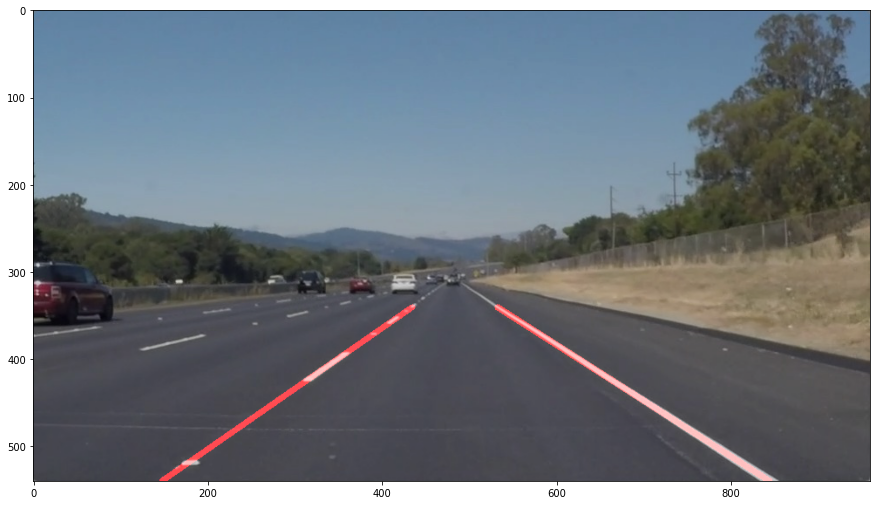

In [20]:
plt.figure(figsize=(15, 10))
plt.imsave("examples/line_drew.jpg", lane_finding_pipeline(image))
plt.imshow(lane_finding_pipeline(image))

In [21]:
def process_image(image):
    result = lane_finding_pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [22]:
white_output = "test_videos_output/solidWhiteRight.mp4"
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)  # NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   5%|▍         | 10/221 [00:00<00:02, 90.50it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 4.57 s, sys: 2.28 s, total: 6.85 s
Wall time: 2.82 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [23]:
HTML(
    """
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(
        white_output
    )
)

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [24]:
yellow_output = "test_videos_output/solidYellowLeft.mp4"
clip2 = VideoFileClip("test_videos/solidYellowLeft.mp4")
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|          | 8/681 [00:00<00:08, 77.21it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 14.2 s, sys: 6.85 s, total: 21.1 s
Wall time: 8.28 s


In [25]:
HTML(
    """
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(
        yellow_output
    )
)

## More Curvey Lanes

Below video has more challenging features - a more curvey road, a change in background color

In [26]:
challenge_output = "test_videos_output/challenge.mp4"

clip3 = VideoFileClip("test_videos/challenge.mp4")
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|▏         | 6/251 [00:00<00:04, 57.25it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 9.71 s, sys: 3.8 s, total: 13.5 s
Wall time: 6.1 s


In [27]:
HTML(
    """
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(
        challenge_output
    )
)

### Probalistic Smoothing, Pipeline Packaging

For curvey lanes, the detected lines are having trouble staying consistent. I have built an improved pipeline that involves probablistic smoothing in the file `lane_detection.py`. Building a pipeline script will allow us to more efficiently tune the hyperparameter, also making the pipeline closer to production environment. Below is when probalistic smoothing is applied the performance on this curvey road is immediately improved

In [28]:
from lane_detection import LaneDetection

lane_detect = LaneDetection(
    cache_size=10,
    gaussian_blur_params={"kernel_size": 5},
    color_filter_params={
        "white_bounds": [np.uint8([0, 150, 0]), np.uint8([255, 255, 255])],
        "yellow_bounds": [np.uint8([10, 0, 100]), np.uint8([20, 255, 255])],
    },
    region_filter_params={"ratios": [0.48, 0.55, 0.51, 0.55]},
    canny_params={"thresholds": [100, 200]},
    slope_params={"bounds": [0.5, 1.5]},
    hough_params={
        "rho": 1,
        "theta": np.pi / 180,
        "threshold": 40,
        "min_line_len": 10,
        "max_line_gap": 1,
    },
    prob_smoothing_params={"current_line_weight": 0.4, "past_lines_weight": 0.6},
)

In [29]:
challenge_output = "test_videos_output/challenge_improved.mp4"

clip3 = VideoFileClip("test_videos/challenge.mp4")
challenge_clip = clip3.fl_image(lane_detect.detect)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   2%|▏         | 5/251 [00:00<00:05, 45.27it/s, now=None]

Moviepy - Building video test_videos_output/challenge_improved.mp4.
Moviepy - Writing video test_videos_output/challenge_improved.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge_improved.mp4
CPU times: user 10.6 s, sys: 5.93 s, total: 16.5 s
Wall time: 7.08 s


In [30]:
HTML(
    """
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(
        challenge_output
    )
)

Oversmoothing could cause lines to be too rigid, with some of the previous straight lines going off the lanes

In [31]:
lane_detect = LaneDetection(
    cache_size=10,
    gaussian_blur_params={"kernel_size": 5},
    color_filter_params={
        "white_bounds": [np.uint8([0, 150, 0]), np.uint8([255, 255, 255])],
        "yellow_bounds": [np.uint8([10, 0, 100]), np.uint8([20, 255, 255])],
    },
    region_filter_params={"ratios": [0.48, 0.55, 0.51, 0.55]},
    canny_params={"thresholds": [100, 200]},
    slope_params={"bounds": [0.5, 1.5]},
    hough_params={
        "rho": 1,
        "theta": np.pi / 180,
        "threshold": 40,
        "min_line_len": 10,
        "max_line_gap": 1,
    },
    prob_smoothing_params={"current_line_weight": 0.4, "past_lines_weight": 0.6},
)

In [32]:
white_output = "test_videos_output/solidWhiteRight_improved.mp4"
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(
    lane_detect.detect
)  # NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   4%|▎         | 8/221 [00:00<00:02, 76.77it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight_improved.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight_improved.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight_improved.mp4
CPU times: user 5.02 s, sys: 2.54 s, total: 7.56 s
Wall time: 3.49 s


In [33]:
HTML(
    """
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(
        white_output
    )
)

In [34]:
lane_detect = LaneDetection(
    cache_size=10,
    gaussian_blur_params={"kernel_size": 5},
    color_filter_params={
        "white_bounds": [np.uint8([0, 150, 0]), np.uint8([255, 255, 255])],
        "yellow_bounds": [np.uint8([10, 0, 100]), np.uint8([20, 255, 255])],
    },
    region_filter_params={"ratios": [0.48, 0.55, 0.51, 0.55]},
    canny_params={"thresholds": [100, 200]},
    slope_params={"bounds": [0.5, 1.5]},
    hough_params={
        "rho": 1,
        "theta": np.pi / 180,
        "threshold": 40,
        "min_line_len": 10,
        "max_line_gap": 1,
    },
    prob_smoothing_params={"current_line_weight": 0.4, "past_lines_weight": 0.6},
)

The improved pipeline performed really well on the below video clip

In [35]:
yellow_output = "test_videos_output/solidYellowLeft_improved.mp4"
clip2 = VideoFileClip("test_videos/solidYellowLeft.mp4")
yellow_clip = clip2.fl_image(lane_detect.detect)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   1%|          | 8/681 [00:00<00:08, 77.73it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft_improved.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft_improved.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft_improved.mp4
CPU times: user 15.3 s, sys: 7.34 s, total: 22.7 s
Wall time: 9.2 s


In [36]:
HTML(
    """
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(
        yellow_output
    )
)